<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Practice Bayesian Modelling on Auto Data


---

In this lab you will get some practice building models with `pymc3`. Please reference the preceding lesson on estimation and regression with `pymc3` for tips on how to code these models up.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.simplefilter('ignore')

### 1. Load the auto data. Perform any cleaning or EDA necessary.

In [32]:
auto = pd.read_csv('../../../../resource-datasets/auto_stats/Auto.csv')

In [33]:
auto.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [34]:
auto.describe()

,mpg,cylinders,displacement,weight,acceleration,year,origin
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,23.515869,5.458438,193.532746,2970.261965,15.555668,75.994962,1.574307
std,7.825804,1.701577,104.379583,847.904119,2.749995,3.690005,0.802549
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.000000,2223.000000,13.800000,73.000000,1.000000
50%,23.000000,4.000000,146.000000,2800.000000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3609.000000,17.100000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [35]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [36]:
print(auto.horsepower.unique())
auto.horsepower = auto.horsepower.map(
    lambda x: np.nan if x == '?' else float(x))
auto.isnull().sum()

['130' '165' '150' '140' '198' '220' '215' '225' '190' '170' '160' '95'
 '97' '85' '88' '46' '87' '90' '113' '200' '210' '193' '?' '100' '105'
 '175' '153' '180' '110' '72' '86' '70' '76' '65' '69' '60' '80' '54'
 '208' '155' '112' '92' '145' '137' '158' '167' '94' '107' '230' '49' '75'
 '91' '122' '67' '83' '78' '52' '61' '93' '148' '129' '96' '71' '98' '115'
 '53' '81' '79' '120' '152' '102' '108' '68' '58' '149' '89' '63' '48'
 '66' '139' '103' '125' '133' '138' '135' '142' '77' '62' '132' '84' '64'
 '74' '116' '82']


mpg             0
cylinders       0
displacement    0
horsepower      5
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [37]:
auto.dropna(inplace=True)

### 2. Create columns indicating if the car brand is from the USA, Asia, or Europe.

Take into account that some brand names are not given correctly.

In [13]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [15]:
auto_us = auto[auto['origin']==1]
auto_eu = auto[auto['origin']==2]
auto_as = auto[auto['origin']==3]

### 3. Build a model with `pymc3` to estimate the difference in MPG between American and European cars.

Make sure to inspect the results visually using `pymc3`'s built-in plotting functions.

When setting up likelihood and priors, you could choose
- a normal distribution for mpg itself 
- a normal distribution for the mean of mpg 
- a uniform distribution for the standard deviation of mpg

Check [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior#cite_note-beta_rate-6) for other suggestions.

In [16]:
import pymc3 as pm

In [17]:
with pm.Model() as model:
    # priors:
    us_mpg_mean = pm.Normal('us_mpg_mean', mu=auto.mpg.mean(), sd=auto.mpg.std())
    eu_mpg_mean = pm.Normal('eu_mpg_mean', mu=auto.mpg.mean(), sd=auto.mpg.std())
    us_mpg_std = pm.Uniform('us_mpg_std', lower=0.01, upper=100)
    eu_mpg_std = pm.Uniform('eu_mpg_std', lower=0.01, upper=100)
    # likelihoods... recall this is P(data|model):
    us_mpg = pm.Normal('us_mpg', mu=us_mpg_mean, sd=us_mpg_std, observed=auto_us.mpg)
    eu_mpg = pm.Normal('eu_mpg', mu=eu_mpg_mean, sd=eu_mpg_std, observed=auto_eu.mpg)
    
    # create deterministic distributions for the parameter differences
    diff_of_means = pm.Deterministic('mean_diff', us_mpg_mean - eu_mpg_mean)
    diff_of_stds = pm.Deterministic('std_diff', us_mpg_std - eu_mpg_std)
    # effect size is the analogue of the t-statistic
    effect_size = pm.Deterministic('effect_size', diff_of_means / (us_mpg_std**2/len(auto_us.mpg)+eu_mpg_std**2/len(auto_eu.mpg))**0.5)

In [18]:
with model:
    # create samples from the posterior distribution
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eu_mpg_std, us_mpg_std, eu_mpg_mean, us_mpg_mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:14<00:00, 733.90draws/s]


In [19]:
model

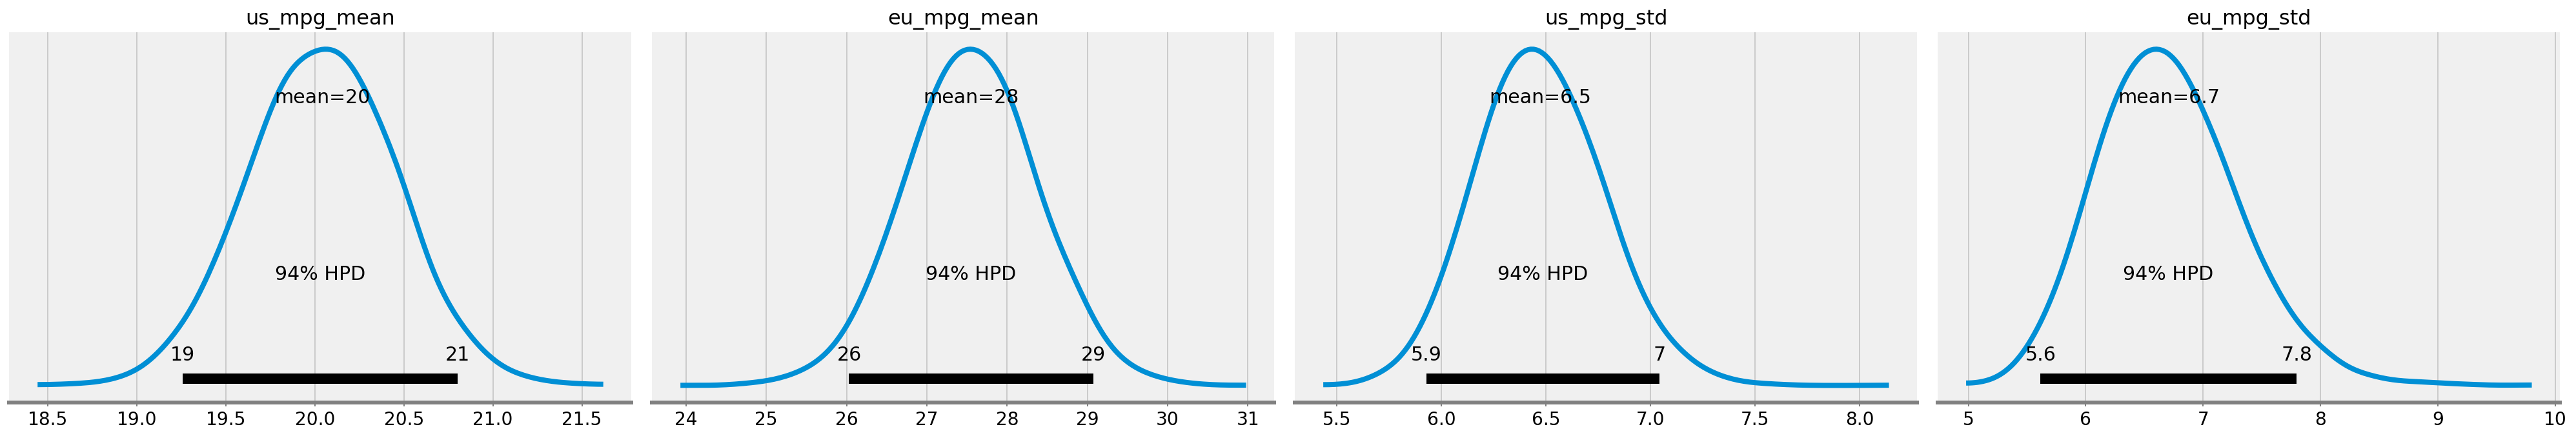

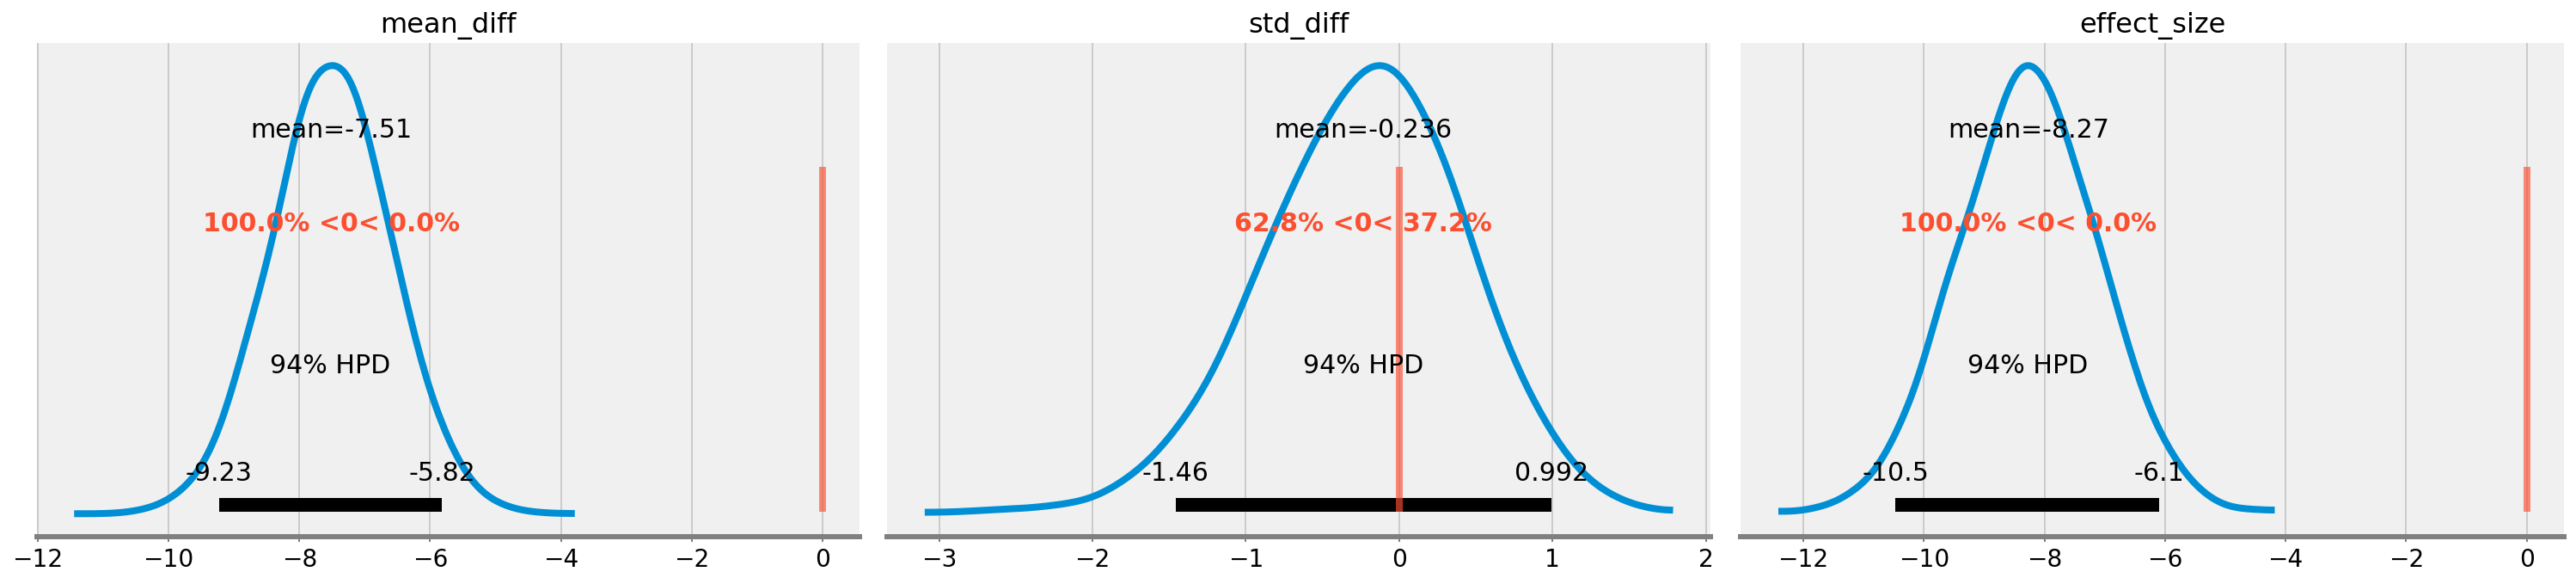

In [23]:
# plot the above metrics:... ie. the posterior distributions

pm.plot_posterior(trace, var_names=['us_mpg_mean', 'eu_mpg_mean', 'us_mpg_std', 'eu_mpg_std'])
pm.plot_posterior(trace, var_names=['mean_diff', 'std_diff', 'effect_size'], ref_val=0, round_to=3)
plt.show()

# the difference in mpg between US and EU cars is seen in mean_diff, and we can use this with a high degree of 
# confidence as the HPD intervals for US and EU don't overlap, as can be seen in the effect_size

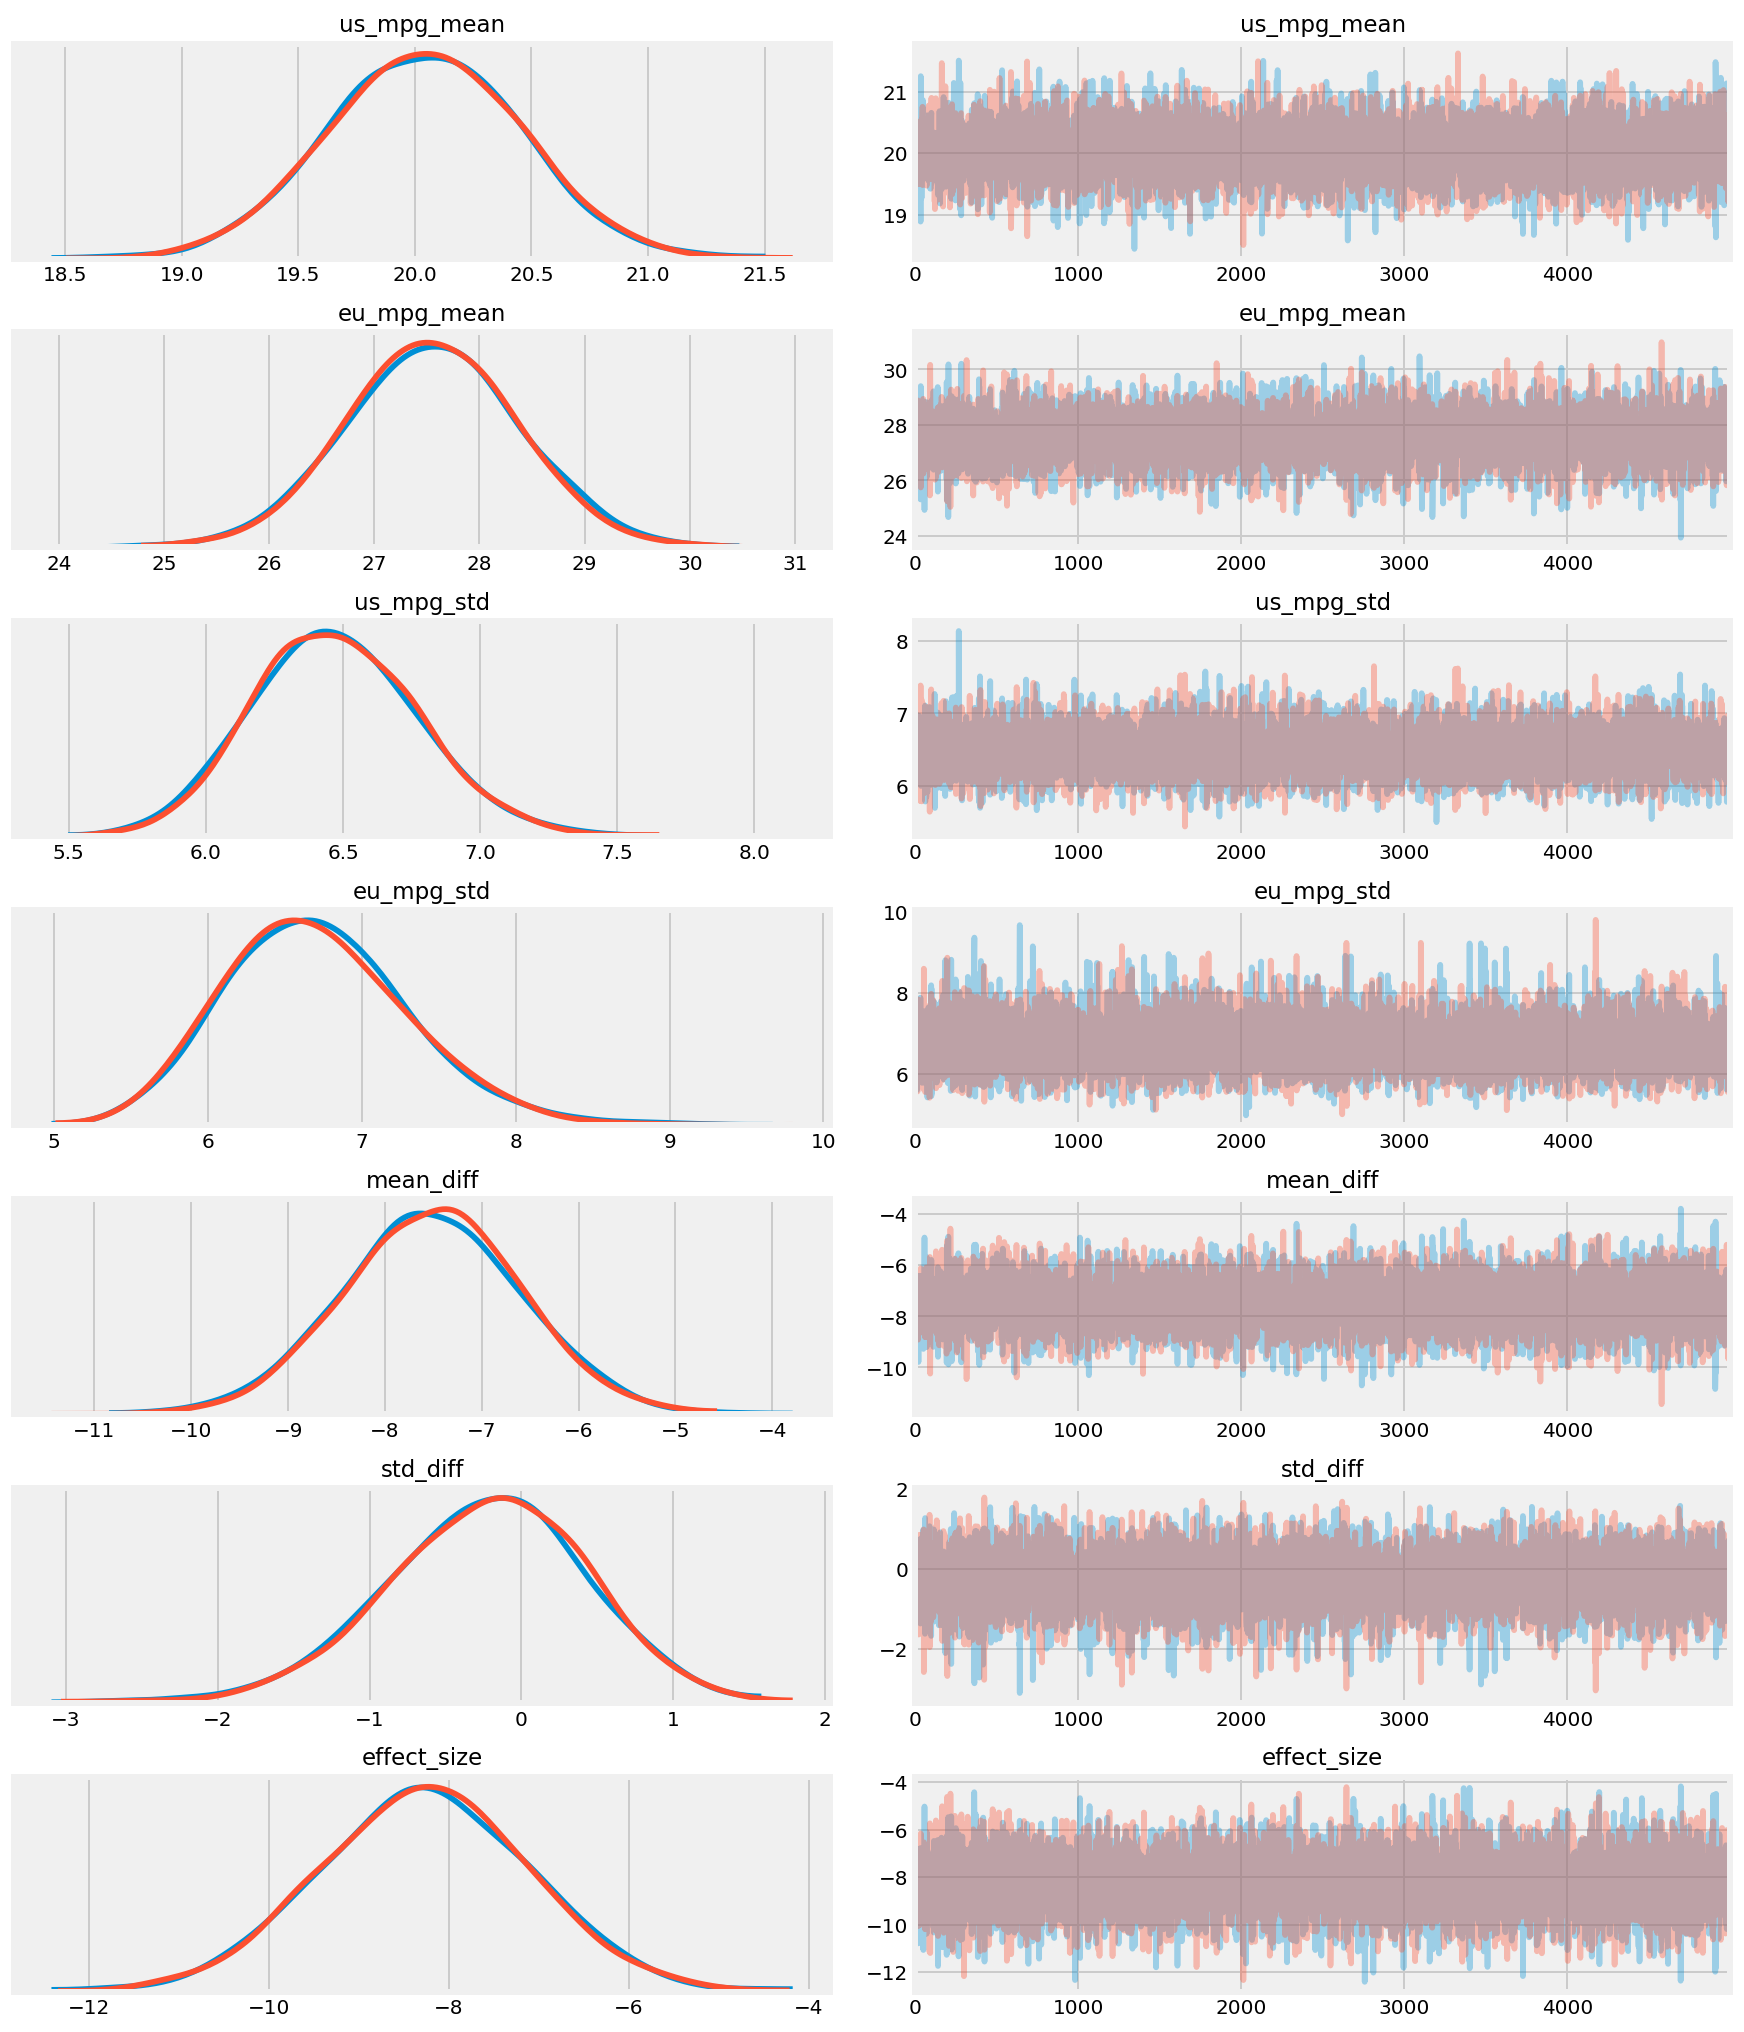

In [24]:
# how did the trace behave? did it converge? are the results trustworthy:

pm.traceplot(trace, combined=False)
plt.show()

# yes, they're fine... red / blue lines are very similar and peaked in the middle

### 4. Build a regression predicting MPG from predictors of your choice using `pymc3`.

Plot out the posterior distributions of your coefficients for your model.

Set up the distributions as in the lesson. For the regression coefficients you can choose normal distributions as a setup.

In [10]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [38]:
auto = pd.get_dummies(auto, columns=['origin'], drop_first=True).drop(columns=['name'])

In [39]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin_2,origin_3
0,18.0,8,307.0,130.0,3504,12.0,70,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,0,0


In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(auto.loc[:,'cylinders':'origin_3']),
                 columns=auto.loc[:,'cylinders':'origin_3'].columns)

# standardizing helps you make same prior assumption across all priors (below)

In [41]:
with pm.Model() as reg:
    # priors
    mpg_std = pm.Uniform('error_std', lower=0.0001, upper=100)
    intercept = pm.Normal('intercept', mu=0, sd=100)
    horsepower_beta = pm.Normal('horsepower_beta', mu=0, sd=100)
    weight_beta = pm.Normal('weight_beta', mu=0, sd=100)
    
    # likelihood (basically you're saying that 'this is my Expected value of mpg (E_mpg), ie. which is a linear 
    # regression model entered below in 'mu' with coefficients sampled from the priors), we then compare that 
    # with the observed auto.mpg:
    
    # Likelihood = 𝑝(data|𝑚𝑜𝑑𝑒𝑙), in linear regression terms the 'data' here are the residuals from fitting some
    # model coefficients: 𝑝(𝜖|𝛽0,𝛽1,…,𝜎)
    
    E_mpg = pm.Normal('y_hat',
                  mu=intercept + (horsepower_beta * X.horsepower) + (weight_beta * X.weight),
                  sd=mpg_std,
                  observed=auto.mpg)
    
    # makes sure to read the Solutions for a vectorial formulation of this.

In [42]:
with reg:
    trace = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [weight_beta, horsepower_beta, intercept, error_std]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:18<00:00, 663.34draws/s]


In [43]:
reg

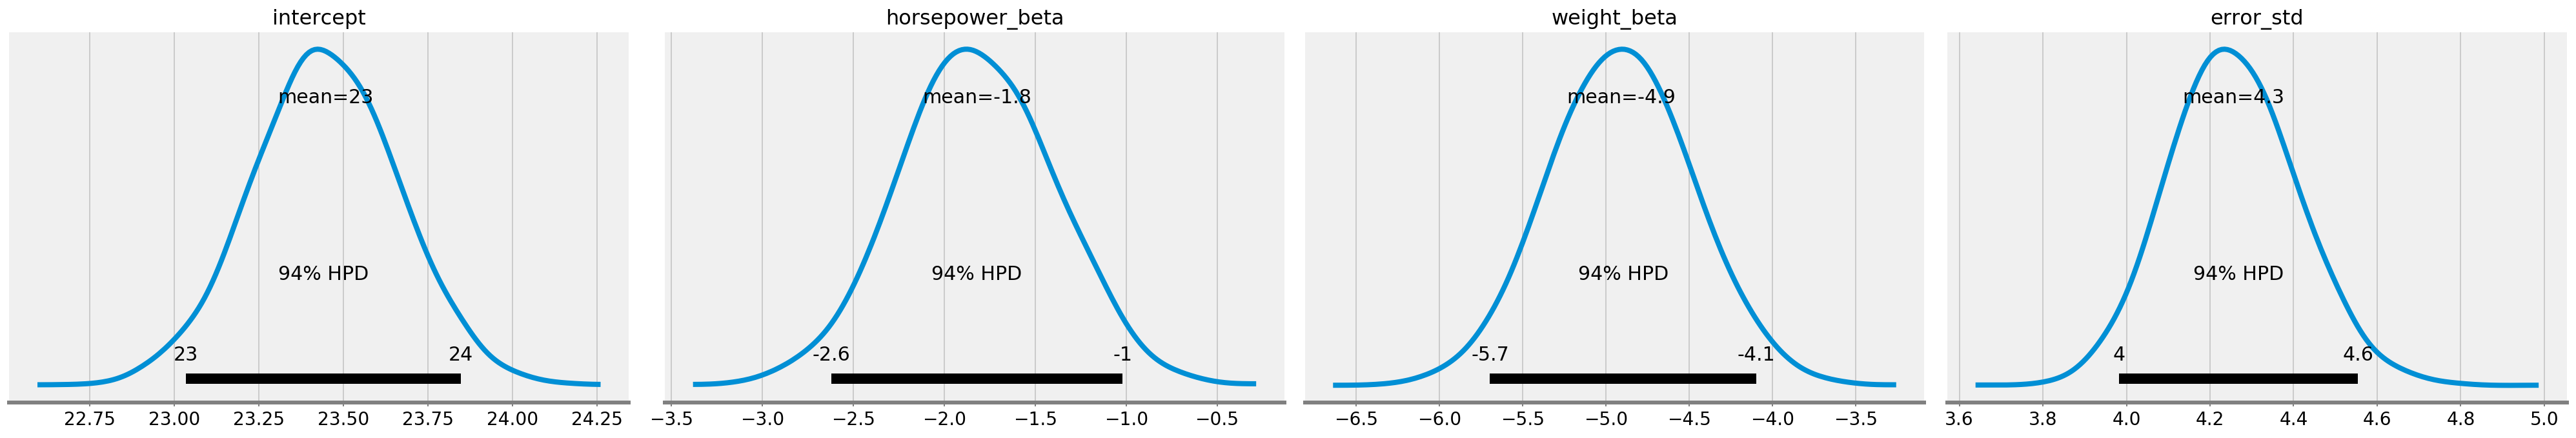

In [44]:
pm.plot_posterior(trace)
plt.show()

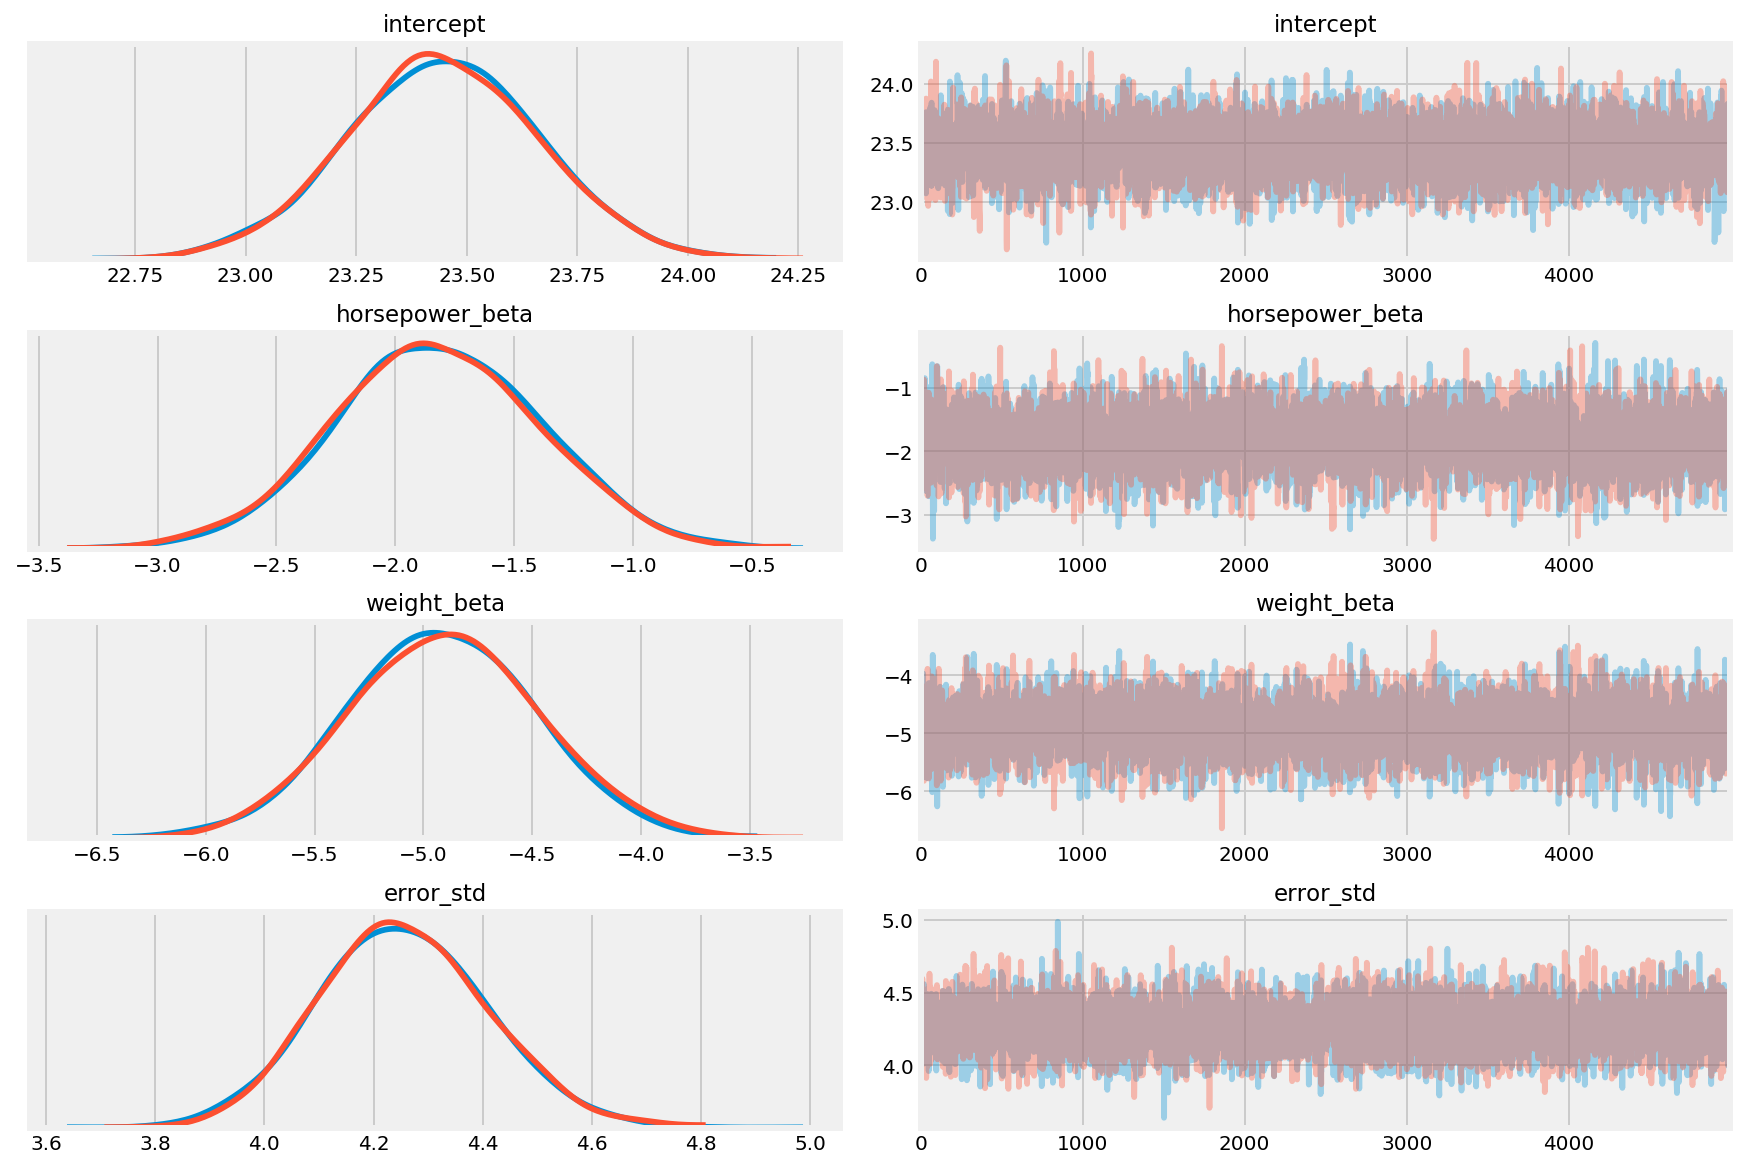

In [45]:
pm.traceplot(trace);

In [46]:
pm.summary(trace, credible_interval=0.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,23.447,0.215,23.015,23.857,0.002,0.002,8267.0,8266.0,8274.0,6479.0,1.0
horsepower_beta,-1.821,0.428,-2.634,-0.967,0.006,0.004,5351.0,5277.0,5354.0,5355.0,1.0
weight_beta,-4.910,0.429,-5.768,-4.093,0.006,0.004,5335.0,5335.0,5335.0,5039.0,1.0
error_std,4.255,0.153,3.957,4.552,0.002,0.001,8944.0,8935.0,8955.0,6937.0,1.0


In [47]:
# now make the predictions using samples of the beta, intercept posterior distribitutions.
preds = pm.sample_posterior_predictive(trace, model=reg)

100%|██████████| 10000/10000 [00:16<00:00, 624.54it/s]


In [48]:
# how do the ensemble average of our 10,000 sampled predictions compare with y?
pm.r2_score(auto.mpg, preds['y_hat'].mean(axis=0)).r2

0.7059722753744058